In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
dirPath = os.getcwd()

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms, models, utils
import albumentations as album

## Transform

In [ ]:
train_transform = album.Compose([
    #album.RandomSizedBBoxSafeCrop(height = 256, width = 256, always_apply=True, p=0.5),
    album.RandomBrightnessContrast(p = 0.5),
    #album.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50, rotate_limit=45, p=0.5),
    #album.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=True, approximate=False, p=0.5),
    album.RandomRotate90(always_apply=True, p=0.5),
    album.HorizontalFlip(p=0.5)
    ],bbox_params=album.BboxParams(format='pascal_voc',label_fields=['category_id']),
)
valid_transform = album.Compose([
    album.CenterCrop(256, 256, always_apply=True, p=1.0)
    ],bbox_params=album.BboxParams(format='pascal_voc',label_fields=['category_id']),
)

totensor = transforms.Compose([ transforms.ToTensor()])

## DataSet

### General Dataset

In [ ]:
import os
import cv2
import json
class cusTrainDataset(Dataset):
    def __init__(self, datasetPath, imgFolder, transforms=None, P=None):
        self.data = datasetPath
        self.imgFolder = imgFolder
        self.transforms = transforms 
        self.P = P

    def __getitem__(self, idx):
        data = self.data[idx]
        # load images
        imagePath = os.path.join(self.imgFolder, data['filename'])
        img = cv2.imread(imagePath, cv2.IMREAD_GRAYSCALE)
        
        # Box
        bboxes = []
        category_id = []
        i = 0
        for box in  data['bbox']:
          Boxs = box.copy()
          Boxs[2] = Boxs[0] + Boxs[2]
          Boxs[3] = Boxs[1] + Boxs[3]
          Boxs = [int(Boxs[0]), int(Boxs[1]), int(Boxs[2]), int(Boxs[3])]
          bboxes.append(Boxs)
          category_id.append(i)
          i += 1
        if self.transforms is not None:
            # arrange transform data
            datus = {"image": img,"bboxes": bboxes, "category_id": category_id}
            # apply transform
            augmented = self.transforms(**datus)
            # get augmented image and bboxes
            img = augmented["image"]
            Boxs = augmented["bboxes"]
        #area
        area = []
        for box in Boxs:
          area.append((box[2]-box[0])*(box[3]-box[1]))
        target = {}
        target["boxes"] = torch.as_tensor(Boxs, dtype=torch.float32)
        target["labels"] = torch.ones(len(Boxs), dtype=torch.int64)
        target["area"] = torch.as_tensor(area, dtype=torch.float32)
        target["image_id"] = torch.tensor([idx])
        target["iscrowd"] = torch.zeros((len(Boxs),), dtype=torch.int64)
        return self.P(img), target

    def __len__(self):
      return len(self.data)

In [ ]:
import os
import cv2
import json
class cusTestDataset(Dataset):
    def __init__(self, datasetPath, imgFolder, transforms=None, P=None):
        self.data = datasetPath
        self.imgFolder = imgFolder
        self.transforms = transforms 
        self.P = P

    def __getitem__(self, idx):
        data = self.data[idx]
        # load images
        imagePath = os.path.join(self.imgFolder, data['filename'])
        img = cv2.imread(imagePath, cv2.IMREAD_GRAYSCALE)
        
        # Box
        bboxes = []
        category_id = []
        i = 0
        for box in  data['bbox']:
          Boxs = box.copy()
          Boxs[2] = Boxs[0] + Boxs[2]
          Boxs[3] = Boxs[1] + Boxs[3]
          Boxs = [int(Boxs[0]), int(Boxs[1]), int(Boxs[2]), int(Boxs[3])]
          bboxes.append(Boxs)
          category_id.append(i)
          i += 1
        if self.transforms is not None:
            # arrange transform data
            datus = {"image": img,"bboxes": bboxes, "category_id": category_id}
            # apply transform
            augmented = self.transforms(**datus)
            # get augmented image and bboxes
            img = augmented["image"]
            Boxs = augmented["bboxes"]
        #area
        area = []
        for box in Boxs:
          area.append((box[2]-box[0])*(box[3]-box[1]))
        target = {}
        target["boxes"] = torch.as_tensor(Boxs, dtype=torch.float32)
        target["labels"] = torch.ones(len(Boxs), dtype=torch.int64)
        target["area"] = torch.as_tensor(area, dtype=torch.float32)
        target["image_id"] = torch.tensor([idx])
        target["iscrowd"] = torch.zeros((len(Boxs),), dtype=torch.int64)
        return self.P(img), target, imagePath

    def __len__(self):
      return len(self.data)

### Train / Valid / Test Loader

In [ ]:
batch_size = 64

In [ ]:
dirPath = os.path.join(os.getcwd(), "drive", "MyDrive", "AIMAS")

In [ ]:
with open(os.path.join(dirPath,"json","train.json"), 'r') as jf:
    trainData = json.load(jf)
def collate_fnn(batch):
    return tuple(zip(*batch))
trainset = cusTrainDataset(
    datasetPath=trainData,
    imgFolder=os.path.join(dirPath,"dataset"),
    transforms=train_transform,
    P=totensor
)
trainLoader = DataLoader(trainset,batch_size=batch_size,collate_fn=collate_fnn)
with open(os.path.join(dirPath,"json","valid.json"), 'r') as jf:
    validData = json.load(jf)
validset = cusTrainDataset(
    datasetPath=validData,
    imgFolder=os.path.join(dirPath,"dataset"),
    transforms=valid_transform,
    P=totensor
)
validLoader = DataLoader(validset,batch_size=batch_size,collate_fn=collate_fnn)
with open(os.path.join(dirPath,"json","test.json"), 'r') as jf:
    testData = json.load(jf)
testset = cusTestDataset(
    datasetPath=testData,
    imgFolder=os.path.join(dirPath,"dataset"),
    transforms=valid_transform,
    P=totensor
)
testLoader = DataLoader(testset,batch_size=batch_size,collate_fn=collate_fnn)

In [ ]:
print(len(trainData))
print(len(validData))
print(len(testData))

4809
601
602


## Model


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms, models, utils
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor, GeneralizedRCNNTransform
model = models.detection.fasterrcnn_resnet50_fpn(weights=models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT,min_size=256)
in_feature = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_feature, 2)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

### Model Information, Criterion and Active Function

#### 改名字 （model_name）

In [ ]:
import numpy as np
valid_loss_min = np.Inf
criterion = nn.CrossEntropyLoss()
Learnning_rate = 0.005
num_epochs = 100
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=Learnning_rate, momentum=0.9, weight_decay=0.0005)
model_name = "model_weight_test.pth"
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=3,gamma=0.1)

### Validation Function



In [ ]:
import numpy as np
# 改了 IOU/f1score 的計算方式 np.zeros and triverse 是目前想到最快的方法，如果你們有其他想法可以在這邊改～
# 1230 6:44 改了range(x1,x2)
def compute_Info(tgdRecList:list, prdRecList:list, prdScoreList:list, threshold:int)->(tuple([int,int,int,int,int])):
    tgtPixel = np.zeros((256, 256), dtype=np.int32)
    prdPixel = np.zeros((256, 256), dtype=np.int32)
    
    for x1,y1,x2,y2 in tgdRecList:
        x1,y1,x2,y2 = int(x1),int(y1),int(x2),int(y2)
        for xIdx in range(x1,x2):
            tgtPixel[xIdx][y1:y2] = 1
    
    scoreList = []
    for [x1,y1,x2,y2], score in zip(prdRecList,prdScoreList):
        x1,y1,x2,y2 = int(x1),int(y1),int(x2),int(y2)
        if score > threshold :
            for xIdx in range(x1,x2):
                prdPixel[xIdx][y1:y2] = 1
            scoreList.append(score)
        else:
            break

    total = tgtPixel + prdPixel
    tP = sum(sum(total == 2))
    fP = sum(sum(prdPixel)) - tP
    fN = sum(sum(tgtPixel)) - tP
    tN = sum(sum(total == 0))
    
    score = 0 if len(scoreList) == 0 else np.mean(scoreList)
    return tP, tN, fP, fN, score


def computeIoU(tP, tN, fP, fN):
    iou = tP / (tP + fN + fP) if (tP + fN + fP) != 0 else 0
    return iou

def computeF1Score(tP, tN, fP, fN):
    precision = tP / (tP + fP) if (tP + fP) != 0 else 0
    recall    = tP / (tP + fN) if (tP + fN) != 0 else 0
    f1score   = (2 * precision * recall) / (recall + precision) if (recall + precision) != 0 else 0
    return f1score

def computeSensitivitySpecificity(tP, tN, fP, fN):
    sensitivity = tP / (tP + fN) if (tP + fN) != 0 else 0 # True Positive Rate
    specificity = tN / (tN + fP) if (tN + fP) != 0 else 0 # True Negative Rate
    return sensitivity, specificity

In [ ]:
# 修正了這裡修正了這裡 : 是算全部大於某個是算全部大於某個threshold時，總覆蓋之總覆蓋之iou/score/f1score

import numpy as np
def validInfo(target, predict, threshold):
    
    tP, tN, fP, fN, score = compute_Info(
                                tgdRecList  = target['boxes'].data.cpu().numpy(),
                                prdRecList  =predict['boxes'].data.cpu().numpy(),
                                prdScoreList=predict['scores'].data.cpu().numpy(),
                                threshold   =threshold)
    
    iou     = computeIoU(tP, tN, fP, fN)
    f1score = computeF1Score(tP, tN, fP, fN)
    
    return score, iou, f1score


def testInfo(target, predict, threshold):
    tP, tN, fP, fN, score = compute_Info(
                                tgdRecList  = target['boxes'].data.cpu().numpy(),
                                prdRecList  =predict['boxes'].data.cpu().numpy(),
                                prdScoreList=predict['scores'].data.cpu().numpy(),
                                threshold   =threshold)
    
    iou     = computeIoU(tP, tN, fP, fN)
    f1score = computeF1Score(tP, tN, fP, fN)
    sensitivity_TPR, specificity_TNR = computeSensitivitySpecificity(tP, tN, fP, fN)
    tarBox = []
    prdBox = []

    for bbox in target['boxes'].data.cpu().numpy():
        tarBox.append(bbox)
    for idx in range(len(predict['boxes'].data.cpu().numpy())):
        if predict['scores'].data.cpu().numpy()[idx] > threshold:
            prdBox.append(predict['boxes'].data.cpu().numpy()[idx])
    
    return score, iou, f1score, tarBox, prdBox, sensitivity_TPR, specificity_TNR


### wandb


In [ ]:
! pip install wandb

In [ ]:
import wandb
os.environ["WANDB_API_KEY"] = "18f9c55605c0842f4e60ebefe6e84fe20a4ada5b"
wandb.login()
wandb.init(project = "[AIMAS]Final_Project_RCNN")

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: yenpochen (aimas). Use `wandb login --relogin` to force relogin


### Backpropagation

In [ ]:
# 增加了一個 lr_scheduler.step() 讓讓learning rate 可以跑
from torch.autograd import Variable
from tqdm import tqdm
# train and Valid
for epoch in range(num_epochs+1):
    print('running epoch: {}'.format(epoch)) 
    
    # Train Loss
    trainlossdict = []
    model.train()
    for Images, targets in tqdm(trainLoader):
        Images = list(image.to(device) for image in Images)
        targets = [{k:v.to(device) for k,v in t.items()} for t in targets]
        loss_dict = model(Images, targets)
        losses = sum(loss for loss in loss_dict.values())
        losses_value = losses.item()
        trainlossdict.append(losses_value)
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        trainlossdict.append(losses_value)
    train_loss = np.mean(trainlossdict)
    wandb.log({"EPOCHS":epoch,  "Train Loss":train_loss})
    print(train_loss)
    lr_scheduler.step()


    # Valid Loss (14sec)
    model.train()
    validlossdict = []
    with torch.no_grad():
        for Images, targets in tqdm(validLoader):
            Images = list(image.to(device) for image in Images)
            targets = [{k:v.to(device) for k,v in t.items()} for t in targets]
            loss_dict = model(Images, targets)
            losses = sum(loss for loss in loss_dict.values())
            losses_value = losses.item()
            validlossdict.append(losses_value)
    valid_loss = np.mean(validlossdict)
    print("valid_loss" , valid_loss)

    wandb.log({"EPOCHS":epoch, "Valid Loss":valid_loss})
    wandb.log({"EPOCHS":epoch, "Learning Rate":optimizer.param_groups[0]['lr']})

    # Validation IoU / F1Score / Score
    # 修改了這裡
    validIoUdict = []
    validf1Scoredict = []
    validScoredict = []
    model.eval()
    with torch.no_grad():
        for Images, targets in tqdm(validLoader):        
            validEpochIoU = []
            Images = list(image.to(device) for image in Images)
            targets = [{k:v.to(device) for k,v in t.items()} for t in targets]
            outputs = model(Images)
            for opt, tar in zip(targets, outputs):
                score, iou, f1score = validInfo(opt, tar, threshold=0.7)
                validIoUdict.append(iou)
                validScoredict.append(score)
                validf1Scoredict.append(f1score)
        valid_IoU = np.mean(validIoUdict)
        valid_Score = np.mean(validScoredict)
        valid_f1score = np.mean(validf1Scoredict)
        
        print(f"valid_IoU : {valid_IoU}, valid_Score : {valid_Score}, valid_f1score : {valid_f1score}")
        wandb.log({"EPOCHS":epoch, "Valid IoU":valid_IoU})
        wandb.log({"EPOCHS":epoch, "Valid Score":valid_Score})
        wandb.log({"EPOCHS":epoch, "Valid f1Score":valid_f1score})
        
    # Check this Epoch model preformance
    
    if valid_loss < valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, valid_loss))
            torch.save(model.state_dict(), os.path.join(dirPath, model_name))
            valid_loss_min = valid_loss
print("I Finish")


NameError: ignored

# for Test

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms, models, utils
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor,GeneralizedRCNNTransform
model = models.detection.fasterrcnn_resnet50_fpn(min_size=256)
in_feature = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_feature, 2)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model.load_state_dict(torch.load(os.path.join(dirPath,"B1.pth"),map_location=torch.device(device)))
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
from tqdm import tqdm
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [ ]:
def showImageAndBBOX(tarBBOX, preBBOX, imgPath:str, info:str):
    
    fig = plt.figure(figsize=[15,5])
    fig.tight_layout()

    ax1 = fig.add_subplot(1,3,1)
    ax2 = fig.add_subplot(1,3,2)
    ax3 = fig.add_subplot(1,3,3)
    ax1.set_title("Label BBOX")
    ax2.set_title(info)
    ax3.set_title("Predict BBOX")
    img1 = cv2.imread(imgPath)
    img2 = cv2.imread(imgPath)
    img3 = cv2.imread(imgPath)

    for x1, y1, x2, y2 in tarBBOX:
        cv2.rectangle(img1, (int(x1),int(y1)), (int(x2),int(y2)), (220, 0, 0), 2)
        cv2.rectangle(img2, (int(x1),int(y1)), (int(x2),int(y2)), (220, 0, 0), 2)
    
    x = 0; y = 2
    for x1, y1, x2, y2 in preBBOX:
        cv2.rectangle(img2, (int(x1),int(y1)), (int(x2),int(y2)), (0, 220, x), y)
        cv2.rectangle(img3, (int(x1),int(y1)), (int(x2),int(y2)), (0, 220, x), y)
        x += 20
        y = 1 if y == 2 else 1

    ax1.imshow(img1); ax1.axis("off")
    ax2.imshow(img2); ax2.axis("off")
    ax3.imshow(img3); ax3.axis("off")
    plt.show()


### Pick Threshold

In [ ]:
# 修改了這裡，將所有判斷寫成一個testInfo 為進去會知道所有的結果

model.eval()


with torch.no_grad():
    threshold = 0.55
    for Images, targets, imgPaths in tqdm(testLoader):        
        Images = list(image.to(device) for image in Images)
        targets = [{k:v.to(device) for k,v in t.items()} for t in targets]
        outputs = model(Images)
        for out, tar, ipth in zip(outputs, targets, imgPaths):
            score, iou, f1score, tarBox, prdBox, sensitivity_TPR, specificity_TNR = testInfo(target=tar, predict=out, threshold=threshold)
            showImageAndBBOX(tarBBOX=tarBox, preBBOX=prdBox, imgPath=ipth, info=f"score : {score:.2f} / iou : {iou:.2f} / f1score : {f1score:.2f}")

In [ ]:
# 修改了這裡，將所有判斷寫成一個testInfo 為進去會知道所有的結果

model.eval()

tnrList = []
tprList = []
thresholdList = []
iouList = []
f1scoreList = []
scoreList = []
for idx in range(20):
    with torch.no_grad():
        threshold = 0.05 * idx
        testIoUList = []
        testScoreList = []
        testf1ScoreList = []
        specificity_TNRList = []
        sensitivity_TPRList = []
        for Images, targets, imgPaths in tqdm(testLoader):        
            
            Images = list(image.to(device) for image in Images)
            targets = [{k:v.to(device) for k,v in t.items()} for t in targets]
            outputs = model(Images)
            for out, tar, ipth in zip(outputs, targets, imgPaths):
                score, iou, f1score, tarBox, prdBox, sensitivity_TPR, specificity_TNR = testInfo(target=tar, predict=out, threshold=threshold)
                sensitivity_TPRList.append(sensitivity_TPR)
                specificity_TNRList.append(specificity_TNR)
                # showImageAndBBOX(tarBBOX=tarBox, preBBOX=prdBox, imgPath=ipth, info=f"score : {score:.2f} / iou : {iou:.2f} / f1score : {f1score:.2f}")
                testIoUList.append(iou)
                testScoreList.append(score)
                testf1ScoreList.append(f1score)
        print(f"threshold : {threshold:.2f} ; iou : {np.mean(testIoUList):.2f} ; score : {np.mean(testScoreList):.2f} ; f1score : {np.mean(testf1ScoreList):.2f}")

        tnrList.append(np.mean(specificity_TNRList))
        tprList.append(np.mean(sensitivity_TPRList))
        iouList.append(np.mean(testIoUList))
        scoreList.append(np.mean(testScoreList))
        f1scoreList.append(np.mean(testf1ScoreList))
        thresholdList.append(threshold)



100%|██████████| 10/10 [03:40<00:00, 22.06s/it]


threshold : 0.00 ; iou : 0.39 ; score : 0.35 ; f1score : 0.52


100%|██████████| 10/10 [00:14<00:00,  1.42s/it]


threshold : 0.05 ; iou : 0.39 ; score : 0.35 ; f1score : 0.52


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


threshold : 0.10 ; iou : 0.41 ; score : 0.46 ; f1score : 0.55


100%|██████████| 10/10 [00:14<00:00,  1.42s/it]


threshold : 0.15 ; iou : 0.42 ; score : 0.53 ; f1score : 0.56


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


threshold : 0.20 ; iou : 0.44 ; score : 0.58 ; f1score : 0.57


100%|██████████| 10/10 [00:14<00:00,  1.41s/it]


threshold : 0.25 ; iou : 0.44 ; score : 0.63 ; f1score : 0.58


100%|██████████| 10/10 [00:13<00:00,  1.40s/it]


threshold : 0.30 ; iou : 0.45 ; score : 0.67 ; f1score : 0.59


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


threshold : 0.35 ; iou : 0.46 ; score : 0.71 ; f1score : 0.59


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


threshold : 0.40 ; iou : 0.46 ; score : 0.74 ; f1score : 0.60


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


threshold : 0.45 ; iou : 0.47 ; score : 0.77 ; f1score : 0.60


100%|██████████| 10/10 [00:14<00:00,  1.42s/it]


threshold : 0.50 ; iou : 0.47 ; score : 0.79 ; f1score : 0.60


100%|██████████| 10/10 [00:14<00:00,  1.41s/it]


threshold : 0.55 ; iou : 0.47 ; score : 0.81 ; f1score : 0.60


100%|██████████| 10/10 [00:14<00:00,  1.42s/it]


threshold : 0.60 ; iou : 0.47 ; score : 0.82 ; f1score : 0.60


100%|██████████| 10/10 [00:14<00:00,  1.42s/it]


threshold : 0.65 ; iou : 0.47 ; score : 0.82 ; f1score : 0.61


100%|██████████| 10/10 [00:14<00:00,  1.41s/it]


threshold : 0.70 ; iou : 0.47 ; score : 0.83 ; f1score : 0.60


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


threshold : 0.75 ; iou : 0.46 ; score : 0.81 ; f1score : 0.59


100%|██████████| 10/10 [00:14<00:00,  1.42s/it]


threshold : 0.80 ; iou : 0.44 ; score : 0.78 ; f1score : 0.56


100%|██████████| 10/10 [00:14<00:00,  1.41s/it]


threshold : 0.85 ; iou : 0.37 ; score : 0.68 ; f1score : 0.48


100%|██████████| 10/10 [00:14<00:00,  1.41s/it]


threshold : 0.90 ; iou : 0.25 ; score : 0.45 ; f1score : 0.32


100%|██████████| 10/10 [00:14<00:00,  1.41s/it]

threshold : 0.95 ; iou : 0.03 ; score : 0.07 ; f1score : 0.05


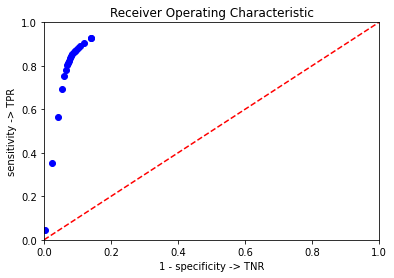

In [ ]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(np.negative(tnrList) + 1, tprList, 'bo')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('sensitivity -> TPR')
plt.xlabel('1 - specificity -> TNR')
plt.show()

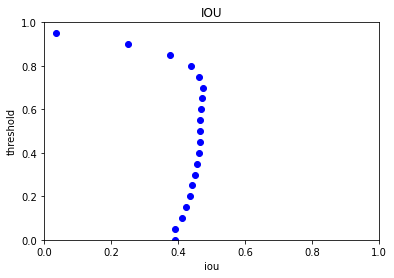

In [ ]:
import matplotlib.pyplot as plt
plt.title('IOU')
plt.plot(iouList, thresholdList, 'bo')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('threshold')
plt.xlabel('iou')
plt.show()

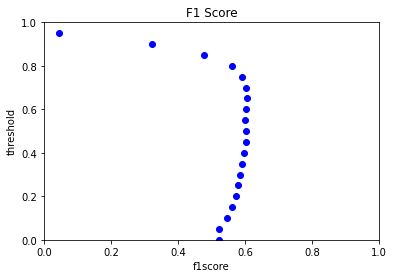

In [ ]:
import matplotlib.pyplot as plt
plt.title('F1 Score')
plt.plot(f1scoreList, thresholdList, 'bo')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('threshold')
plt.xlabel('f1score')
plt.show()

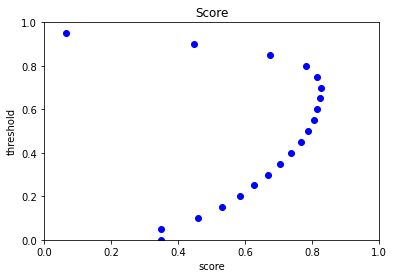

In [ ]:
import matplotlib.pyplot as plt
plt.title('Score')
plt.plot(scoreList,thresholdList,'bo')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('threshold')
plt.xlabel('score')
plt.show()